# Genotype data preprocessing
This module documents output from the genotype section of command generator MWE and explained the purpose for each of the command. The file used in this page can be found at [here](https://drive.google.com/drive/folders/16ZUsciZHqCeeEWwZQR46Hvh5OtS8lFtA?usp=sharing).

The genotype section consist of the yellow section of the following workflow.

> ../images/data_preprocessing.png (544.5 KiB):

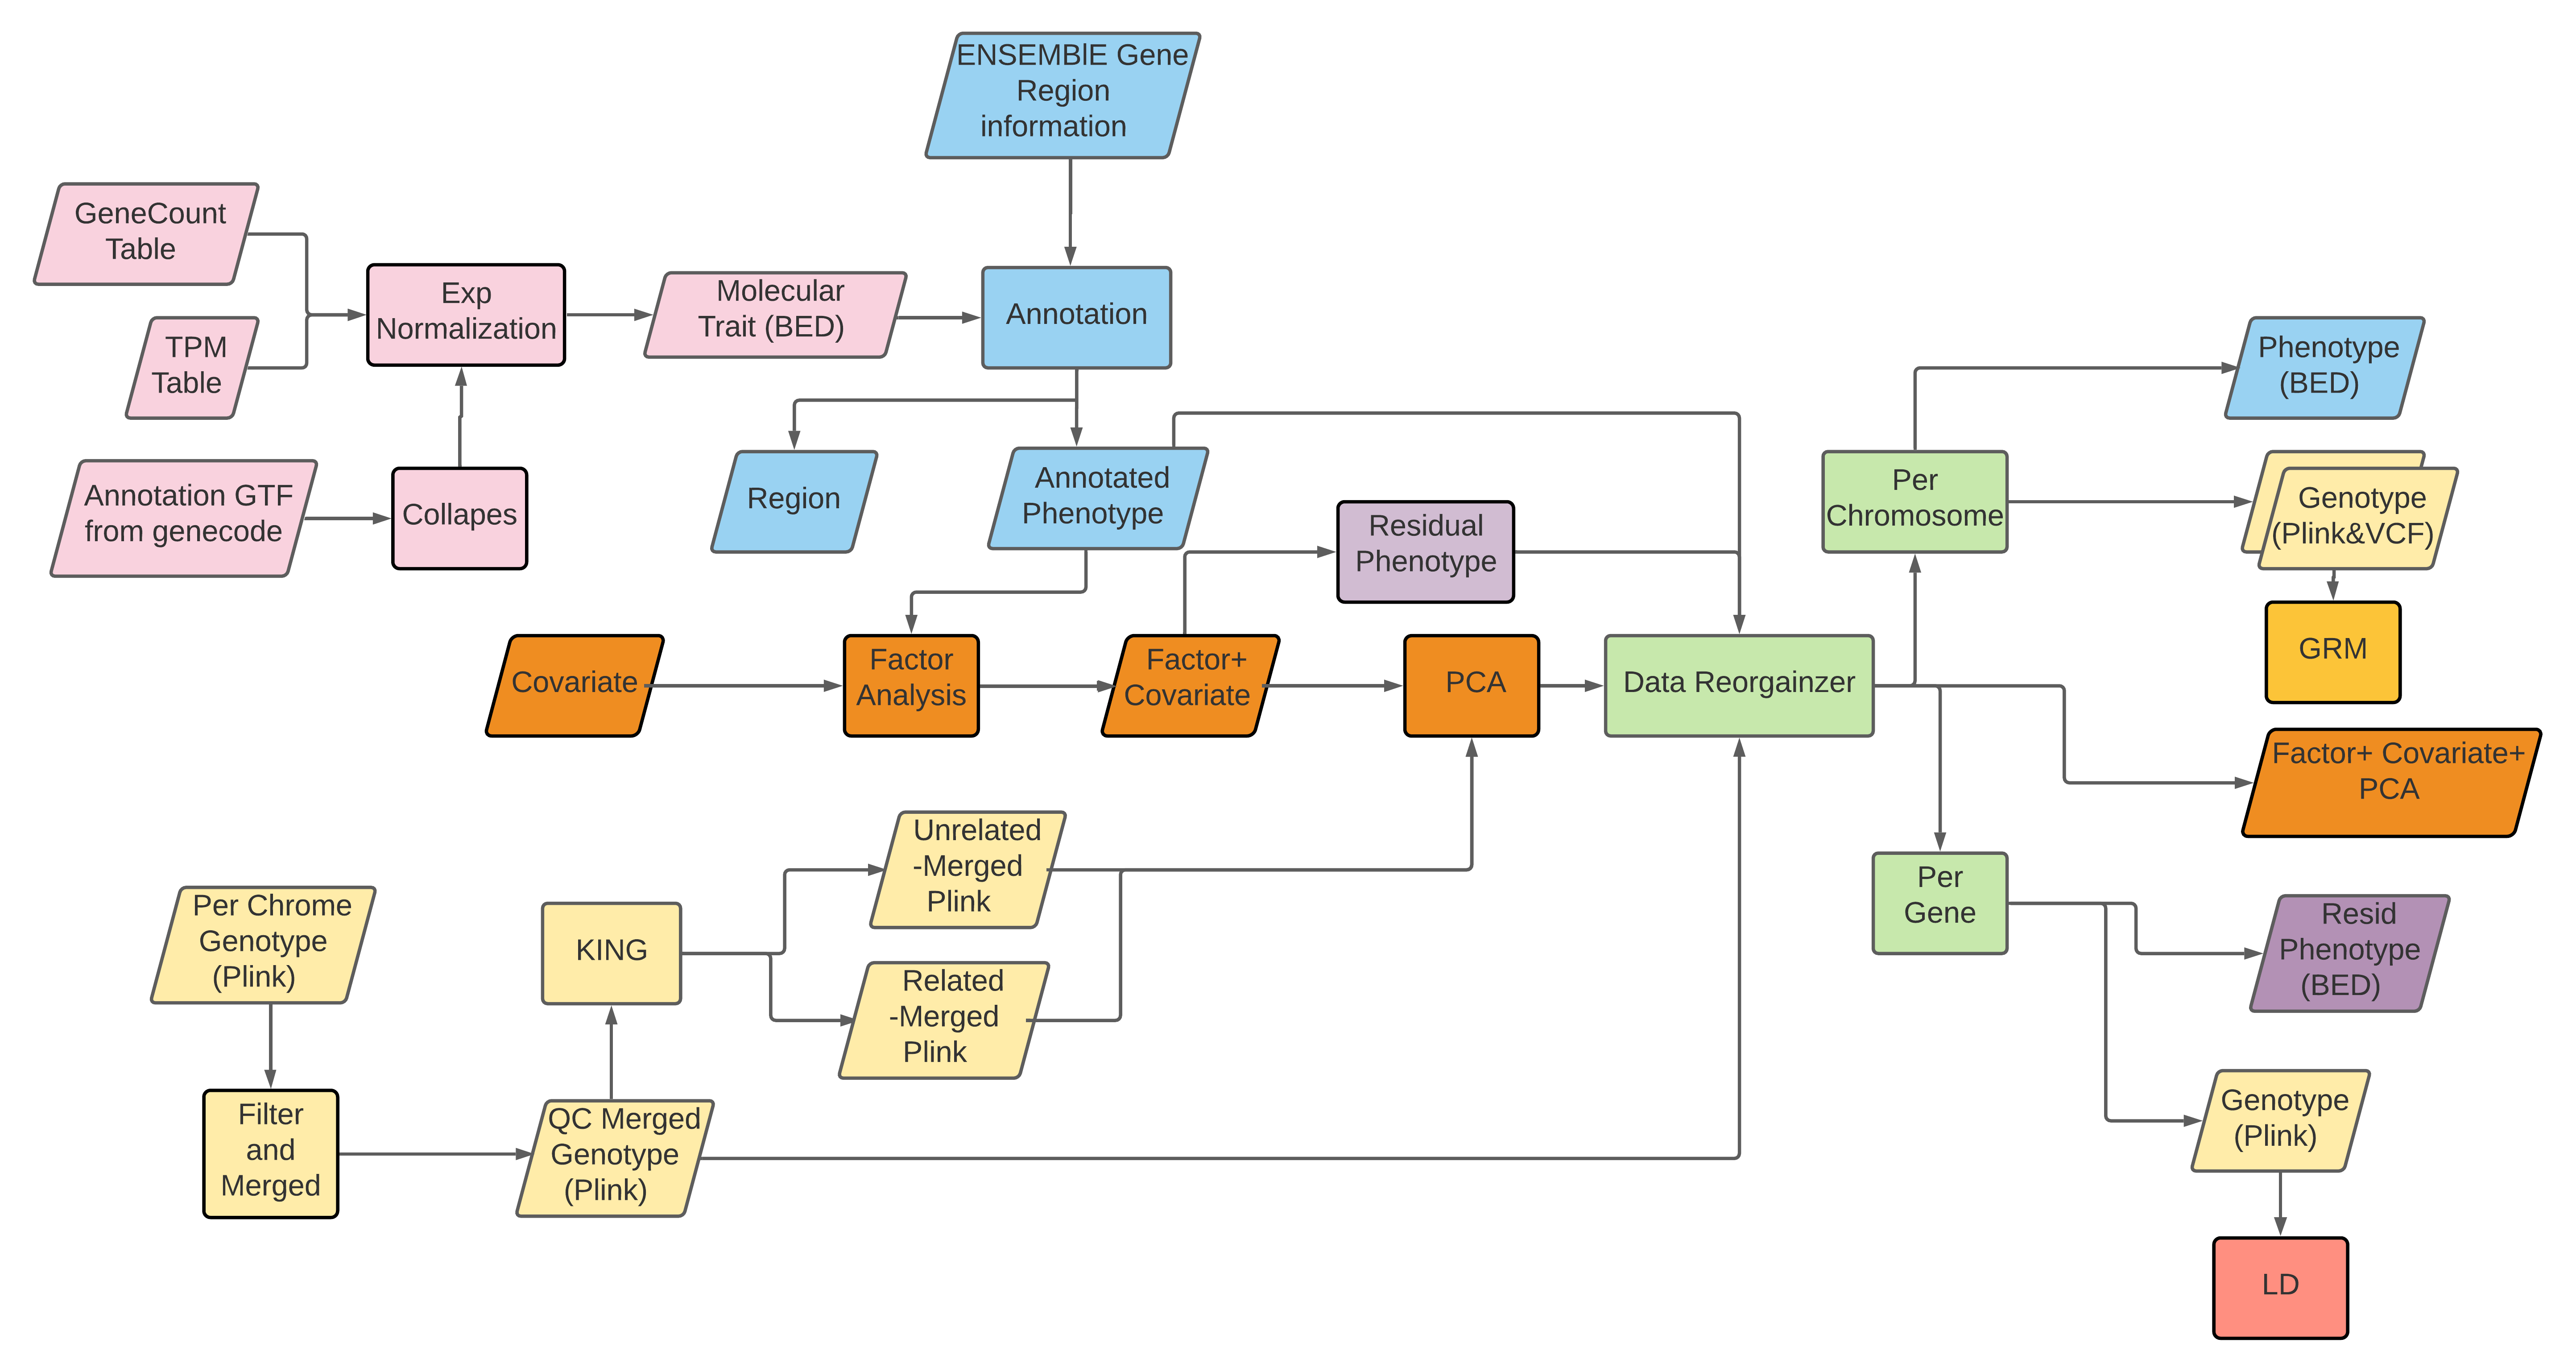

In [3]:
%preview ../images/data_preprocessing.png

## Overview

### Analysis steps

1. Genotype data quality control (QC). See here for the [QC default settings](https://cumc.github.io/xqtl-pipeline/code/data_preprocessing/genotype/GWAS_QC.html).
2. Principle component analysis (PCA) based QC, and PC computation for each sub-population available in the genotype data.
3. Genomic relationship matrix (GRM) computation (optional, when in Step 1 genotype QC detects related individuals or the input is known to have related individuals).

### Input data requirement

1. Genotype data. See here for [format details](https://cumc.github.io/xqtl-pipeline/code/data_preprocessing/genotype/genotype_formatting.html).
2. [Optional] a sample information file to specific population information, if external data such as HapMap or 1000 Genomes are to be integrated to the PCA analysis to visualize and assess population structure in the genotype data. See here for [format details](https://cumc.github.io/xqtl-pipeline/code/data_preprocessing/genotype/genotype_formatting.html).

## QC for VCF files

This step extract the rsID for the known varriants, so that we can distinguish them from the novel variants we had in our study. The procedure/rationale is [explained in this post](https://hbctraining.github.io/In-depth-NGS-Data-Analysis-Course/sessionVI/lessons/03_annotation-snpeff.html).

In [ ]:
sos run pipeline/VCF_QC.ipynb dbsnp_annotate \
    --genoFile reference_data/00-All.vcf.gz \
    --cwd output/reference_data \
    --container containers/bioinfo.sif \
    -J 50 -c csg.yml -q csg --add_chr

Perform QC on VCF files. The QC-ed data will also be exported to PLINK format for next steps analysis. The QC procedure includes:
1. Handling the formatting of multi-allelic sites, 
2. Genotype and variant level filtering based on genotype calling qualities. 

    2.1. Genotype depth filters: For WES data, UK Biobank recommends **SNPs DP>10 and Indels DP>10 for indels.** However we think for WGS we can be less stringent, or simply rely on GQ. Users can set it to 1 eg, `--DP 1 --DP-indel 1 `

    2.2. Genotype quality GQ>20.

    2.3. At least one sample per site passed the allele balance threshold >= 0.15 for SNPs and >=0.20 for indels (heterozygous variants). Allele balance is calculated for heterozygotes as the number of bases supporting the least-represented allele over the total number of base observations.

3. Known/novel variants annotation
4. Summary statistics before and after QC, in particular the ts/tv ratio, to assess the effectiveness of QC.

3 and 4 above are for explorative analysis on the overall quality assessment of genotype data in the VCF files. We annotate known and novel variants because ts/tv are expected to be different between known and novel variants, and is important QC metric to assess the effectiveness of our QC. 
After the procedure was done, the output will be converted to a plink bed/bim/fam binary format for downstream analysis.

In [ ]:
sos run VCF_QC.ipynb qc \
    --genoFile data/mwe/mwe_genotype.vcf.gz \
    --dbsnp-variants data/reference_data/00-All.add_chr.variants.gz \
    --reference-genome data/reference_data/GRCh38_full_analysis_set_plus_decoy_hla.noALT_noHLA_noDecoy_ERCC.fasta \
    --cwd output/genotype_4 --container ./containers/bioinfo.sif

## Genotype QC for PCA

To accuratly estimate the PCs for the genotype. We split participants based on their kinship coefficients, estimated by king. We have implemented a graph-based method to avoid removing unrelated participants that are in a family. However, this option is disable by default due to the long running time it required. User can enable this option by changing the `--no-maximize_unrelated` to `--maximize_unrelated`

In [ ]:
sos run pipeline/GWAS_QC.ipynb king \
   --cwd data_preprocessing/MWE/genotype_data \
   --genoFile MWE.bed \
   --name MWE \
   --keep-samples data_preprocessing/MWE/sampleSheetAfterQC.filtered_geno.txt \
   --container containers/bioinfo.sif \
   --walltime 48h   --no-maximize_unrelated

Variant level and sample level QC on unrelated individuals using missingness > 10% ,MAF>5% , and LD-prunning in preparation for PCA analysis:

In [ ]:
sos run pipeline/GWAS_QC.ipynb qc \
   --cwd data_preprocessing/MWE/genotype_data \
   --genoFile data_preprocessing/MWE/genotype_data/MWE.MWE.unrelated.bed \
   --exclude-variants /mnt/mfs/statgen/snuc_pseudo_bulk/Ast/genotype/dupe_snp_to_exclude \
   --maf-filter 0.05 \
   --container containers/bioinfo.sif \

Extract previously selected variants from related individuals in preparation for PCA, only applying missingness filter at sample level,

In [ ]:
sos run pipeline/GWAS_QC.ipynb qc_no_prune \
   --cwd data_preprocessing/MWE/genotype_data \
   --genoFile data_preprocessing/MWE/genotype_data/MWE.MWE.related.bed \
   --maf-filter 0 \
   --geno-filter 0 \
   --mind-filter 0.1 \
   --hwe-filter 0 \
   --keep-variants data_preprocessing/MWE/genotype_data/MWE.MWE.unrelated.filtered.prune.in  \
   --container containers/bioinfo.sif  \
   --mem 40G

## PCA
The PCA was done based on the related/unrelated samples generated above. PCs was estimated based on the unrelated sample, then the PCs for related sample will be calculated based on the estimated eigen loading from the unrelated sample. The PCs with a cumulative PVE of 70% will be used in determined outliner and used in downstream analysis.

In [ ]:
sos run pipeline/PCA.ipynb flashpca \
   --cwd output/data_preprocessing/MWE/pca output/data_preprocessing/MWE/pca \
   --genoFile data_preprocessing/MWE/genotype_data/MWE.MWE.unrelated.filtered.prune.bed \
   --container containers/flashpcaR.sif

The uniformly distributed PVE is due to [MAF filtering](https://github.com/cumc/brain-xqtl-analysis/blob/main/analysis/Wang_Columbia/snuc_pseudo_bulk/impact_on_pca_pve.ipynb)

> /mnt/mfs/statgen/snuc_pseudo_bulk/eight_tissue_analysis/MWE/QTL_association/output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.scree.png (56.7 KiB):

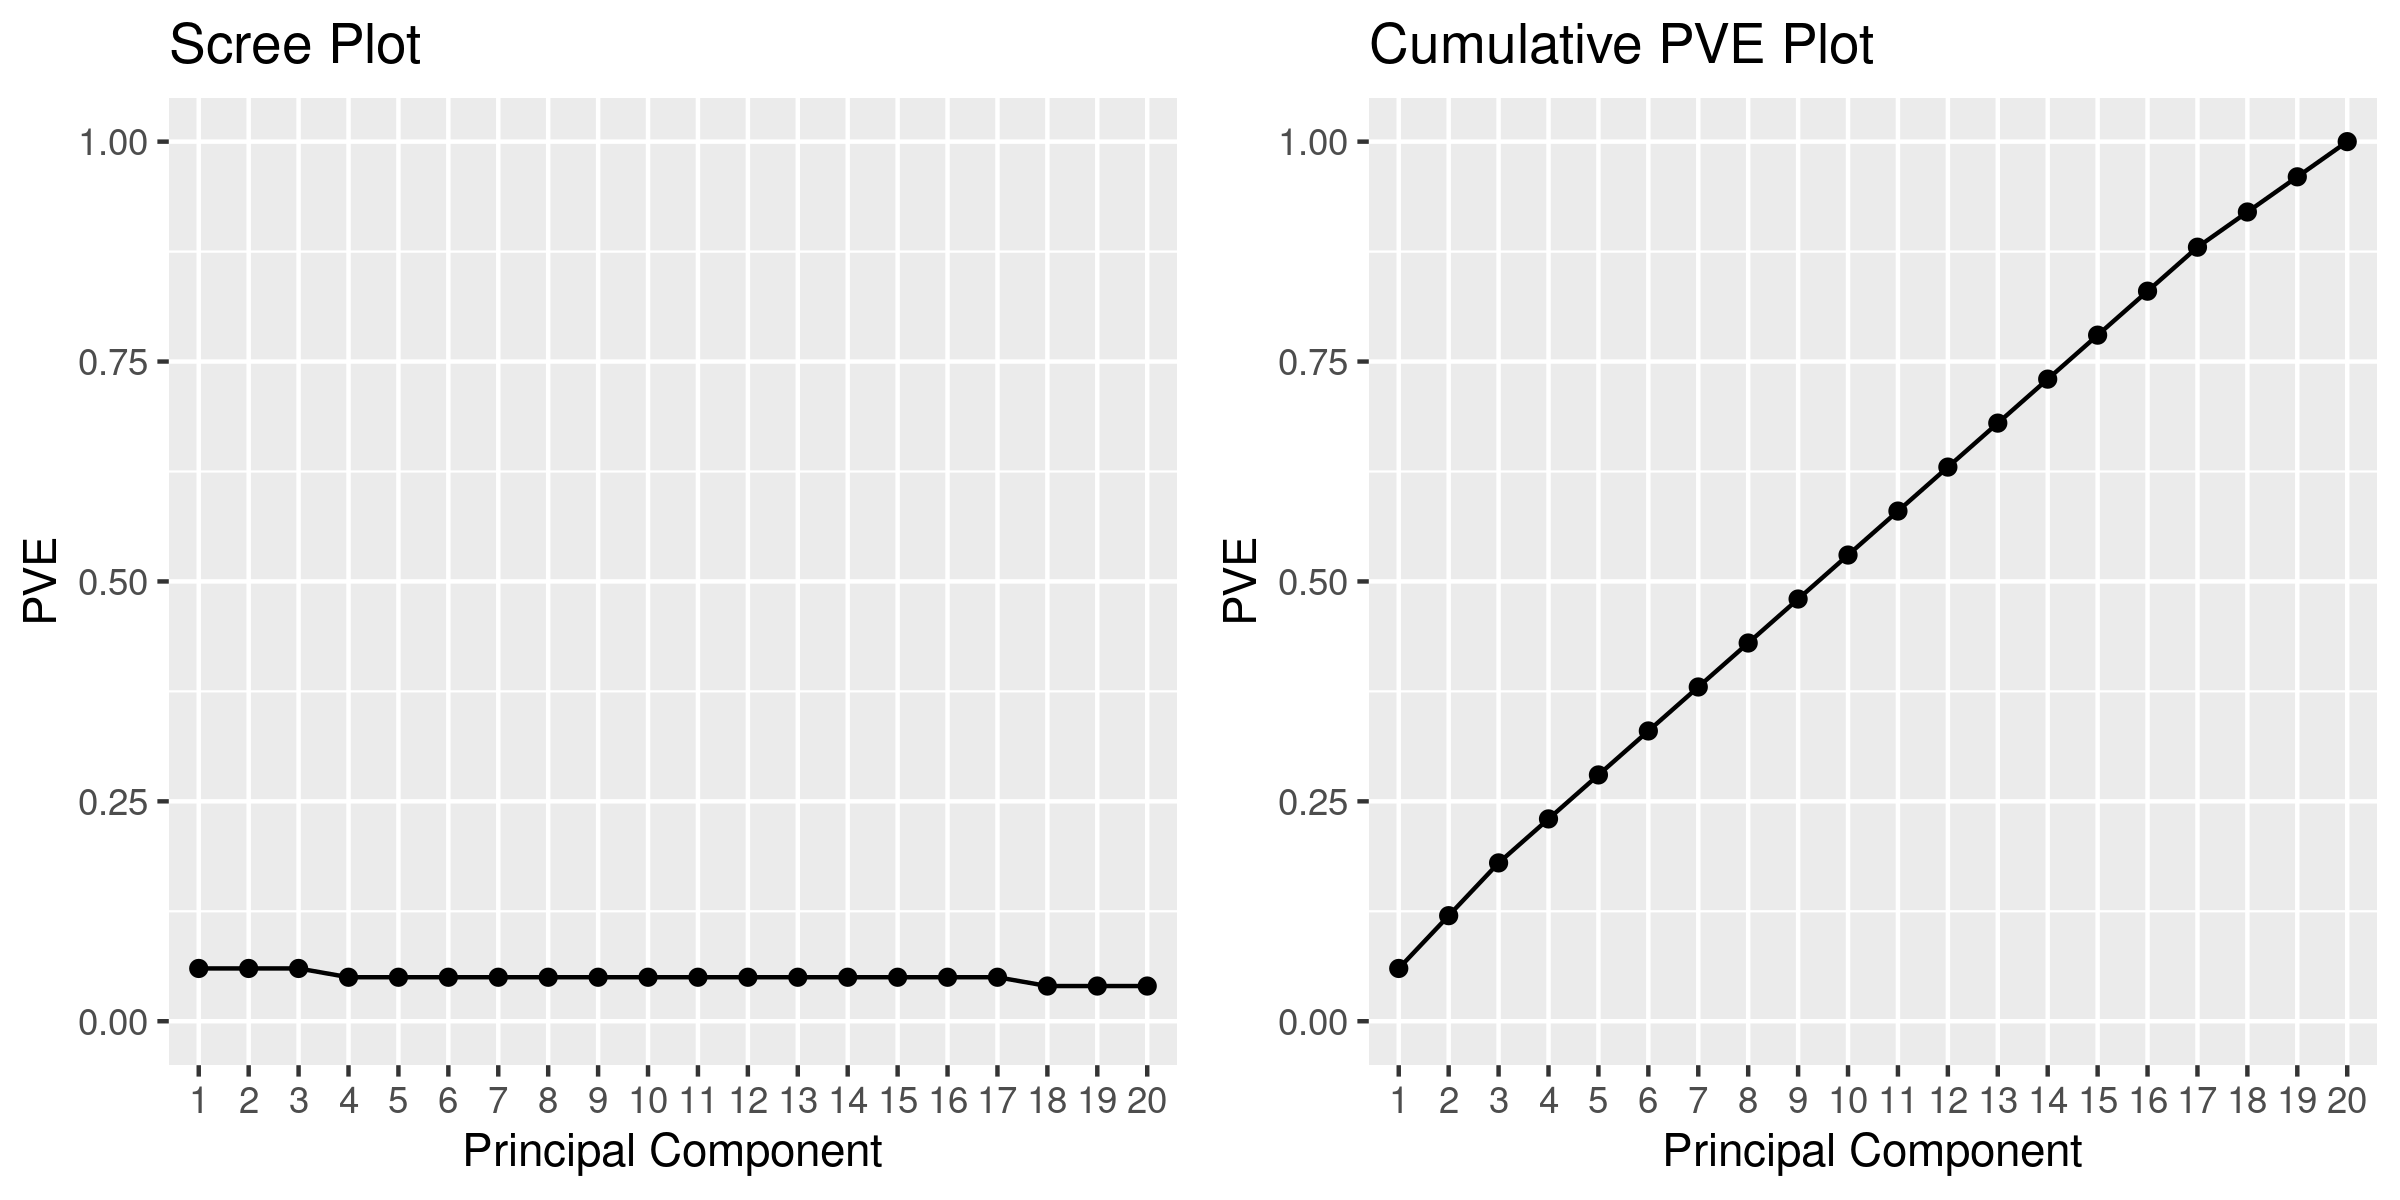

In [1]:
%preview data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.scree.png

In [ ]:
sos run pipeline/PCA.ipynb project_samples \
        --cwd output/data_preprocessing/MWE/pca output/data_preprocessing/MWE/pca \
        --genoFile data_preprocessing/MWE/genotype_data/MWE.MWE.related.filtered.extracted.bed \
        --pca-model  output/data_preprocessing/MWE/pca/MWE.MWE.unrelated.filtered.prune.pca.rds \
        --maha-k `awk '$3 < 0.7' output/data_preprocessing/MWE/pca/MWE.MWE.unrelated.filtered.prune.pca.scree.txt | tail -1 | cut -f 1  ` \
        --container containers/flashpcaR.sif

> /mnt/mfs/statgen/snuc_pseudo_bulk/eight_tissue_analysis/MWE/QTL_association/output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.pc.png (1.5 MiB):

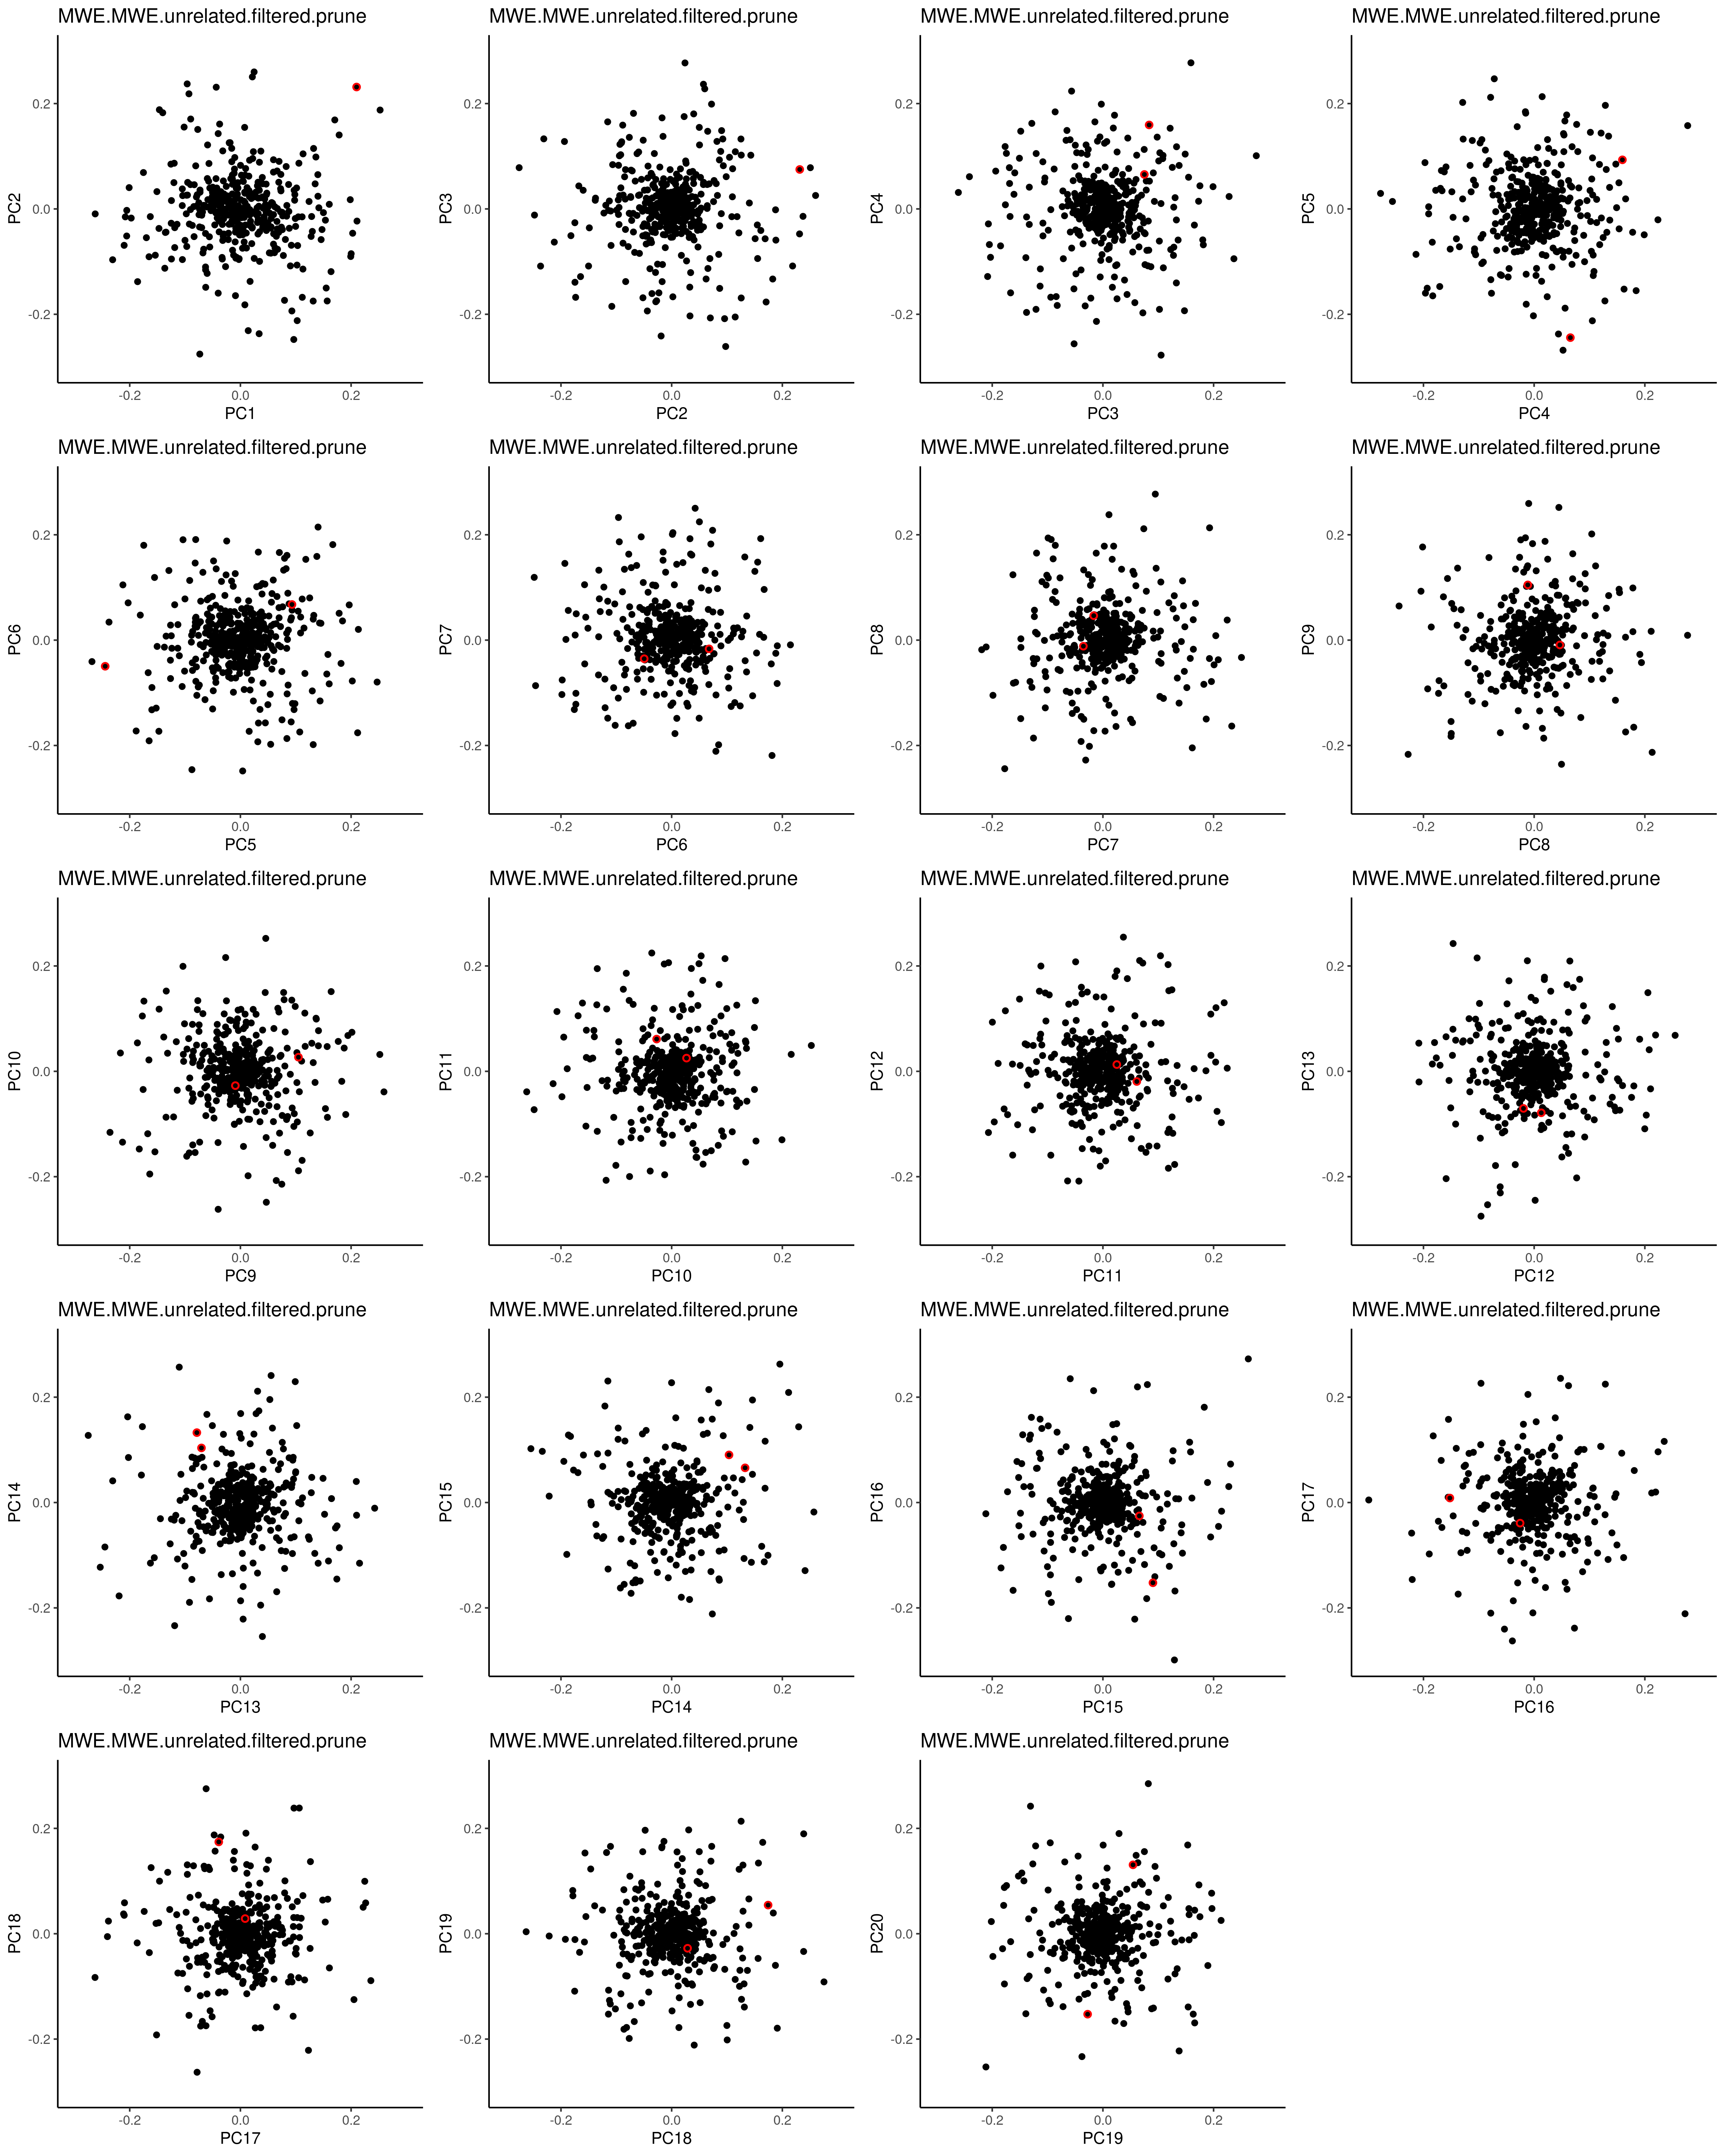

In [2]:
%preview data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.pc.png

## Finalized genotype QC, optionally as a result of PCA
### Common varriant:
In our demo, the genotype data was filtered by the criteria of missingness > 10% and MAF>5% as shown below. User can detemined the level of filtering by changing the generated command manually.

In [ ]:
sos run pipeline/GWAS_QC.ipynb qc_no_prune \
    --cwd output/data_preprocessing \
    --genoFile output/data_preprocessing/mwe_genotype.add_chr.leftnorm.filtered.bed \
    --maf-filter 0.05 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe-filter 1e-06   \
    --mem 40G  \
    --container containers/bioinfo.sif

### Remove outlier

PCA analysis (see covariate formatting page) can possibly provide us a list of outlier samples to be removed from the genotype data. We can optionally remove them and perform genotype data QC.

Removal of samples is a complicated decision that require human descretion. Therefore outlier removal is not performed automatically. The `--remove-samples` parameter take a two columns table that illustrated by  `output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.outliers` in `MWEoutput.tar.gz`

In [ ]:
sos run pipeline/GWAS_QC.ipynb qc_no_prune \
    --cwd output/data_preprocessing \
    --genoFile output/data_preprocessing/mwe_genotype.add_chr.leftnorm.filtered.bed \
    --maf-filter 0.05 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe-filter 1e-06   \
    --mem 40G  \
    --container containers/bioinfo.sif \
    --remove-samples output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.outliers

Also remove outliers and keep the same variant as unrelated individuals, in related individuals:

To fully illustrate how PCA and PCA based QC is done on sample with **multiple populations (a more complicated but potentially very useful setting)**, please try out the example documented in the [PCA analysis module](https://cumc.github.io/xqtl-pipeline/code/data_preprocessing/genotype/PCA.html) with a different example data-set.

### For common and infrequent variants

Additionally, we provide a version with variants having sample minor allele count MAC >= 5, for the sake of convenience focusing our single variant analysis. It should be noted that mac and maf don't overwrite each other within our module. It is up to plink to decide how to handle the secnario of both `--maf-filter` and `--mac-filter` > 0.

In [ ]:
mac="5"

sos run pipeline/GWAS_QC.ipynb qc \
   --cwd data_preprocessing/MWE/genotype_data \
   --genoFile data_preprocessing/MWE/genotype_data/MWE.MWE.unrelated.bed \
   --exclude-variants /mnt/mfs/statgen/snuc_pseudo_bulk/Ast/genotype/dupe_snp_to_exclude \
   --maf-filter 0.05 \
    --mac-filter $mac \
    --name no_outlier_mac$mac \
   --container containers/bioinfo.sif


sos run pipeline/GWAS_QC.ipynb qc_no_prune \
   --cwd data_preprocessing/MWE/genotype_data \
   --genoFile data_preprocessing/MWE/genotype_data/MWE.MWE.related.bed \
   --maf-filter 0 \
   --geno-filter 0 \
   --mind-filter 0.1 \
   --hwe-filter 0 \
    --mac-filter $mac \
    --name no_outlier_mac$mac \
   --keep-variants data_preprocessing/MWE/genotype_data/MWE.MWE.unrelated.filtered.prune.in  \
   --container containers/bioinfo.sif  \
   --mem 40G

sos run pipeline/GWAS_QC.ipynb qc_no_prune \
    --cwd output/data_preprocessing \
    --genoFile output/data_preprocessing/mwe_genotype.add_chr.leftnorm.filtered.bed \
    --maf-filter 0.05 \
    --geno-filter 0.1 \
    --mind-filter 0.1 \
    --hwe-filter 1e-06   \
    --mem 40G  \
    --mac-filter $mac \
    --name no_outlier_mac$mac \
    --container containers/bioinfo.sif \
    --remove-samples output/data_preprocessing/MWE/pca/MWE.MWE.related.filtered.extracted.pca.projected.outliers

**FIXME: still need to add in section for VCF formatted file processing after PCA**